In [1]:
%pip install -U lightgbm==3.3.2
%pip install implicit

     |████████████████████████████████| 2.0 MB 4.2 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 18.5 MB 496 kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [4]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("/content/drive/MyDrive/HM-new/") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [5]:
from src.data import DataHelper
from src.data.metrics import map_at_k, hr_at_k, recall_at_k

from src.retrieval.rules import (
    OrderHistory,
    ALS,
    BPR,
    UserGroupTimeHistory,
    OrderHistoryDecay,
    ItemPair,
    TimeHistory,
    ItemCF,
    UserGroupItemCF
)
from src.retrieval.collector import RuleCollector

from src.features import full_sale, week_sale, repurchase_ratio, popularity, period_sale

from src.utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity,
)

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
data_dir = Path("/content/drive/MyDrive/HM-new/data/")
model_dir = Path("/content/drive/MyDrive/HM-new/models/")

In [25]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "LargeRecall"
TEST = True # * Set as `False` when do local experiments to save time

In [19]:
TEST_BATCH_SIZE = 140000
TEST_BATCH_NUM = 10# 1371980 / 70000

In [10]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)
if not os.path.exists(data_dir/"processed"/VERSION_NAME):
    os.mkdir(data_dir/"processed"/VERSION_NAME)

Pepare data: encoding ids and preprocessing

In [11]:
dh = DataHelper(data_dir)

In [12]:
# data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

In [13]:
data = dh.load_data(name="encoded_full")

In [14]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [20]:
user_info = data["inter"].groupby(['customer_id'])['price'].mean().reset_index(name='mean_price')
user_info['purchase_ability'] = pd.qcut(user_info['mean_price'],5,labels=False)
del user_info['mean_price']

In [21]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)
data['user'] = data['user'].merge(user_info, on='customer_id', how='left')

In [ ]:
# * WEEK_NUM = 0: test
# * WEEK_NUM = 1: valid
# * WEEK_NUM > 1: train
for week in range(1):
    if week == 0 and not TEST:
        continue
    # * use sliding window to generate candidates
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")

    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins','user_gender']], on='customer_id', how='left')
    train = train.merge(user_info, on='customer_id', how='left')

    train['t_dat'] = pd.to_datetime(train['t_dat'])
    last_week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=7)]
    last_2week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=14)]
    last_60day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=60)]
    last_80day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=80)]

    customer_list = submission['customer_id'].values
    for batch_num, batch in enumerate(range(0,len(customer_list),TEST_BATCH_SIZE)):
        print(f"Batch {batch_num}")
        batch_customer = customer_list[batch:batch+TEST_BATCH_SIZE]
        # * ========================== Retrieval Strategies ==========================

        candidates = RuleCollector().collect(
            week_num = week,
            trans_df = trans,
            customer_list=batch_customer,
            rules=[
                ALS(batch_customer, last_60day, n=200, iter_num=25),
                BPR(batch_customer, last_80day, n=200, iter_num=350),
                UserGroupTimeHistory(data, batch_customer, last_week, ['age_bins'], n=200, scale=True, name='1'),
                UserGroupTimeHistory(data, batch_customer, last_week, ['purchase_ability'], n=200, scale=True, name='2'),
                UserGroupTimeHistory(data, batch_customer, last_week, ['user_gender'], n=200, scale=True, name='3'),
                OrderHistory(train, days=35, n=200),
                OrderHistoryDecay(train, days=7, n=200),
                TimeHistory(batch_customer, last_week, n=200),

                ItemCF(last_80day, last_2week, top_k=10, name='1'),
                ItemCF(last_60day, last_2week, top_k=10, name='2'),
                ItemCF(last_2week, last_2week, top_k=10, name='3'),
                UserGroupItemCF(last_80day, last_2week, 'age_bins', top_k=10, name='1'),
                UserGroupItemCF(last_60day, last_2week, 'age_bins', top_k=10, name='2'),
                UserGroupItemCF(last_2week, last_2week, 'age_bins', top_k=10, name='3'),
                UserGroupItemCF(last_80day, last_2week, 'purchase_ability', top_k=10, name='4'),
                UserGroupItemCF(last_60day, last_2week, 'purchase_ability', top_k=10, name='5'),
                UserGroupItemCF(last_2week, last_2week, 'purchase_ability', top_k=10, name='6'),
            ],
            min_pos_rate=0.0,
            norm=False,
            # norm_type='minmax',
            compress=False,
        )

        candidates, _ = reduce_mem_usage(candidates)
        candidates = (
            pd.pivot_table(
                candidates,
                values="score",
                index=["customer_id", "article_id"],
                columns=["method"],
                aggfunc=np.sum,
            )
            .reset_index()
        )
        rule_names = [x for x in candidates.columns if x not in ["customer_id", "article_id"]]
        tmp = candidates[rule_names]
        for f in rule_names:
            tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
        candidates['score'] = tmp[rule_names].sum(axis=1)
        del tmp
        gc.collect()
        candidates['rank'] = candidates.groupby(['customer_id'])['score'].rank(ascending=False)
        candidates = candidates[candidates['rank']<=200]
        # del candidates['rank'], candidates['score']

        candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate_{batch_num}.pqt")

Week 0: [2020-09-23, 2020-09-30)
Batch 0


Retrieve items by rules:  88%|████████▊ | 15/17 [18:44<02:01, 60.83s/it]

In [ ]:
# * WEEK_NUM = 0: test
# * WEEK_NUM = 1: valid
# * WEEK_NUM > 1: train
for week in range(1,WEEK_NUM):
    # * use sliding window to generate candidates
    if week == 0 and not TEST:
        continue
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")

    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins','user_gender']], on='customer_id', how='left')
    train = train.merge(user_info, on='customer_id', how='left')

    train['t_dat'] = pd.to_datetime(train['t_dat'])
    last_week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=7)]
    last_2week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=14)]
    last_60day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=60)]
    last_80day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=80)]

    customer_list = valid["customer_id"].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            ALS(customer_list, last_60day, n=200, iter_num=25),
            BPR(customer_list, last_80day, n=200, iter_num=350),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=200, scale=True, name='1'),
            UserGroupTimeHistory(data, customer_list, last_week, ['purchase_ability'], n=200, scale=True, name='2'),
            UserGroupTimeHistory(data, customer_list, last_week, ['user_gender'], n=200, scale=True, name='3'),
            OrderHistory(train, days=35, n=200),
            OrderHistoryDecay(train, days=7, n=200),
            TimeHistory(customer_list, last_week, n=200),

            ItemCF(last_80day, last_2week, top_k=10, name='1'),
            ItemCF(last_60day, last_2week, top_k=10, name='2'),
            ItemCF(last_2week, last_2week, top_k=10, name='3'),
            UserGroupItemCF(last_80day, last_2week, 'age_bins', top_k=10, name='1'),
            UserGroupItemCF(last_60day, last_2week, 'age_bins', top_k=10, name='2'),
            UserGroupItemCF(last_2week, last_2week, 'age_bins', top_k=10, name='3'),
            UserGroupItemCF(last_80day, last_2week, 'purchase_ability', top_k=10, name='4'),
            UserGroupItemCF(last_60day, last_2week, 'purchase_ability', top_k=10, name='5'),
            UserGroupItemCF(last_2week, last_2week, 'purchase_ability', top_k=10, name='6'),
        ],
        min_pos_rate=0.0,
        norm=False,
        # norm_type='minmax',
        compress=False,
    )

    candidates, _ = reduce_mem_usage(candidates)
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )
    rule_names = [x for x in candidates.columns if x not in ["customer_id", "article_id"]]
    tmp = candidates[rule_names]
    for f in rule_names:
        tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
    candidates['score'] = tmp[rule_names].sum(axis=1)
    del tmp
    gc.collect()
    candidates['rank'] = candidates.groupby(['customer_id'])['score'].rank(ascending=False)
    candidates = candidates[candidates['rank']<=200]
    # del candidates['rank'], candidates['score']

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

In [ ]:
del train, valid, customer_list, candidates
gc.collect()

44

## Feature engineering


In [ ]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [ ]:
# merge `product_code`
inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")
# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7

In [ ]:
inter = inter.sort_values(["customer_id", "t_dat"]).reset_index(drop=True)

In [ ]:
inter.shape

Week Sale, Last Week Sale, Week Sale Trend

In [ ]:
inter["i_sale"] = week_sale(inter, ["article_id"])
inter["p_sale"] = week_sale(inter, ["product_code"])
inter["i_sale_uni"] = week_sale(inter, ["article_id"], True)
inter["p_sale_uni"] = week_sale(inter, ["product_code"], True)
inter["lw_i_sale"] = week_sale(inter, ["article_id"], step=1) # * last week sale
inter["lw_p_sale"] = week_sale(inter, ["product_code"], step=1)
inter["lw_i_sale_uni"] = week_sale(inter, ["article_id"], True, step=1)
inter["lw_p_sale_uni"] = week_sale(inter, ["product_code"], True, step=1)

inter["i_sale_ratio"] = inter["i_sale"] / (inter["p_sale"] + 1e-6)
inter["i_sale_uni_ratio"] = inter["i_sale_uni"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_sale_ratio"] = inter["lw_i_sale"] / (inter["lw_p_sale"] + 1e-6)
inter["lw_i_sale_uni_ratio"] = inter["lw_i_sale_uni"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_uni_ratio"] = inter["i_sale"] / (inter["i_sale_uni"] + 1e-6)
inter["p_uni_ratio"] = inter["p_sale"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_uni_ratio"] = inter["lw_i_sale"] / (inter["lw_i_sale_uni"] + 1e-6)
inter["lw_p_uni_ratio"] = inter["lw_p_sale"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_sale_trend"] = (inter["i_sale"] - inter["lw_i_sale"]) / (inter["lw_i_sale"] + 1e-6)
inter["p_sale_trend"] = (inter["p_sale"] - inter["lw_p_sale"]) / (inter["lw_p_sale"] + 1e-6)

item_feats = [
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
]
inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

for f in tqdm(item_feats):
    inter[f"{f}_sale"] = week_sale(inter, [f], f"{f}_sale")
    inter[f"lw_{f}_sale"] = week_sale(inter, [f], f"{f}_sale", step=1)
    inter[f"{f}_sale_trend"] = (inter[f"{f}_sale"] - inter[f"lw_{f}_sale"]) / (inter[f"lw_{f}_sale"] + 1e-6)

inter = inter.drop(columns=item_feats)

100%|██████████| 6/6 [01:52<00:00, 18.79s/it]


In [ ]:
_, inter["i_1w_sale_rank"], inter["i_1w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
_, inter["p_1w_sale_rank"], inter["p_1w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_2w_sale"], inter["i_2w_sale_rank"], inter["i_2w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_2w_sale"], inter["p_2w_sale_rank"], inter["p_2w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_3w_sale"], inter["i_3w_sale_rank"], inter["i_3w_sale_norm"] = period_sale(
    inter, ["article_id"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_3w_sale"], inter["p_3w_sale_rank"], inter["p_3w_sale_norm"] = period_sale(
    inter, ["product_code"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_4w_sale"], inter["i_4w_sale_rank"], inter["i_4w_sale_norm"] = period_sale(
    inter, ["article_id"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_4w_sale"], inter["p_4w_sale_rank"], inter["p_4w_sale_norm"] = period_sale(
    inter, ["product_code"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)

Repurchase Ratio

In [ ]:
inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'])
inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'])

Popularity

In [ ]:
inter['i_pop'] = popularity(inter, 'article_id', week_num=WEEK_NUM)
inter['p_pop'] = popularity(inter, 'product_code', week_num=WEEK_NUM)

Already Bought Item

In [ ]:
# inter["purchased_item"] = purchased_before(inter, ["article_id"])
# inter["purchased_pro"] = purchased_before(inter, ["product_code"])

Save data

In [ ]:
inter.shape

(31788324, 65)

In [ ]:
inter.to_parquet(data_dir / "processed/processed_inter.pqt")

## Merge Features


In [ ]:
inter = pd.read_parquet(data_dir / "processed/processed_inter.pqt")
# data["inter"] = inter

In [ ]:
#* embeddings from DSSM model
dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)
# * embeddings from YouTubeDNN model
yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)

In [ ]:
for col in inter.columns:
    inter[col] = np.nan_to_num(inter[col])

In [ ]:
for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    if i == 0:
        chunk_size = int(candidate.shape[0] * 0.5)
        # tmpl = []
        for chunk,batch in enumerate(range(0, candidate.shape[0], chunk_size)):
            sub_candidate = candidate.iloc[batch:batch+chunk_size-1]
            # * merge features
            sub_candidate = merge_week_data(data, inter, i, sub_candidate)
            sub_candidate['article_id'] = sub_candidate['article_id'].astype(int)
            sub_candidate['customer_id'] = sub_candidate['customer_id'].astype(int)
            # * merge DSSM user and item embeddings
            sub_candidate["dssm_similarity"] = calc_embd_similarity(sub_candidate, dssm_user_embd, dssm_item_embd)
            # * merge YouTubeDNN user and item embeddings
            sub_candidate["yt_similarity"] = calc_embd_similarity(sub_candidate, yt_user_embd, yt_item_embd)
            print(f"Chunk {chunk} done...")
            # tmpl.append(sub_candidate)
            sub_candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate_{chunk}.pqt")
    else:
        # * merge features
        candidate = merge_week_data(data, inter, i, candidate)
        print(candidate['week'].unique())
        # * merge DSSM user and item embeddings
        candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
        # * merge YouTubeDNN user and item embeddings
        candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)
    candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")

  0%|          | 0/6 [00:00<?, ?it/s]

68984
[1 0]



100%|██████████| 1380/1380 [00:04<00:00, 312.98it/s]

 33%|███▎      | 2/6 [03:05<06:10, 92.60s/it]

72019
[2 1]



100%|██████████| 1441/1441 [00:05<00:00, 273.46it/s]

 50%|█████     | 3/6 [06:14<06:39, 133.06s/it]

75822
[3 2]



100%|██████████| 1517/1517 [00:05<00:00, 272.30it/s]

 67%|██████▋   | 4/6 [09:52<05:29, 164.75s/it]

80253
[4 3]



100%|██████████| 1605/1605 [00:05<00:00, 278.25it/s]

 83%|████████▎ | 5/6 [13:42<03:07, 187.17s/it]

72035
[4 5]



100%|██████████| 1441/1441 [00:05<00:00, 281.66it/s]

100%|██████████| 6/6 [17:28<00:00, 174.69s/it]


In [ ]:
del dssm_user_embd, dssm_item_embd, yt_user_embd, yt_item_embd
gc.collect()

65

In [ ]:
del candidate

## Ranking


In [ ]:
candidates = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    #***
    candidates[i] = candidates[i][candidates[i]['rank']<=70]
    #***
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")

100%|██████████| 5/5 [01:07<00:00, 13.46s/it]


In [ ]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",

        # 'i_w_full_sale_ratio',
        # 'i_2w_full_sale_ratio',
        'p_w_full_sale_ratio',
        'p_2w_full_sale_ratio',
        # 'i_week_above_daily_sale',
        'p_week_above_full_sale',
        # 'i_2w_week_above_daily_sale',
        'p_2w_week_above_daily_sale',
        'product_type_no_daily_sale',
        # 'i_product_type_no_daily_sale_ratio',
        'p_product_type_no_daily_sale_ratio',

        # 'i_3w_sale',
        # 'i_3w_sale_rank',
        # 'i_3w_sale_norm',
        'p_3w_sale',
        'p_3w_sale_rank',
        'p_3w_sale_norm',
        # 'i_4w_sale',
        # 'i_4w_sale_rank',
        # 'i_4w_sale_norm',
        'p_4w_sale',
        'p_4w_sale_rank',
        'p_4w_sale_norm',
        # "rank",
        # "score",
        # "prob"
    ]
]
cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",

    "user_gender",
    "article_gender",
    "season_type"
]

In [ ]:
# * Convert categorical featues as `CategoricalDtype`
cate_dict = {}        
for feat in tqdm(cat_features):
    if feat in data['user'].columns:
        value_set = set(data['user'][feat].unique())
    elif feat in data['item'].columns:
        value_set = set(data['item'][feat].unique())
    else:
        value_set = set(data['inter'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)

100%|██████████| 17/17 [00:01<00:00, 16.58it/s]


In [ ]:
for i in tqdm(range(1,WEEK_NUM)):
    for feat in cat_features:
        candidates[i][feat] = candidates[i][feat].astype(cate_dict[feat])

100%|██████████| 5/5 [00:21<00:00,  4.22s/it]


### Train


In [ ]:
params = {
    "objective": "lambdarank",#"lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",#"map",
    "max_depth":6,
    "num_leaves": 128,
    "learning_rate": 0.03,

    "verbose": -1,
    "eval_at": 12,
    # 'device':'gpu'
}

In [ ]:
def train_model(train, valid, train_group, valid_group):

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        group=train_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        group=valid_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        model_dir / f"lgb_ranker_1.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [ ]:
def train_binary_model(full_data, valid_week_num, train_week_num=4):
    print("Validating week:", valid_week_num)
    train = full_data[
        (valid_week_num < full_data["week"])
        & (full_data["week"] <= valid_week_num + train_week_num)
    ]
    valid = full_data[full_data["week"] == valid_week_num]

    print("Train positive rate:", train.label.mean())  # 0.9946384702188372 4-week


    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        model_dir / f"lgb_ranker_{valid_week_num}.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [ ]:
for f in feats:
    for i in range(2,WEEK_NUM):
        if f not in candidates[i].columns:
            candidates[i][f] = np.nan

In [ ]:
train = pd.concat([candidates[i] for i in range(2, WEEK_NUM)], ignore_index=True)
valid = candidates[1]

In [ ]:
del candidates
gc.collect()

65

In [ ]:
train = train.sort_values(by=["week", "customer_id"], ascending=True).reset_index(drop=True)
valid = valid.sort_values(by=["customer_id"], ascending=True).reset_index(drop=True)
print("Train positive rate:", train.label.mean())  # 0.9946384702188372 4-week

In [ ]:
gc.collect()

In [ ]:
train_group = train[["customer_id", "article_id", "week"]]
train_group = train_group.astype("int32")  # * convert to int to avoid `0` in groupby count result
train_group = (train_group.groupby(["week", "customer_id"])["article_id"].count().values)

In [ ]:
valid_group = valid[["customer_id", "article_id"]]
valid_group = valid_group.astype("int32")  # * convert to int to avoid `0` in groupby count result
valid_group = valid_group.groupby(["customer_id"])["article_id"].count().values

In [ ]:
train = train[feats+['label']]
valid = valid[feats+['label']]

In [ ]:
gc.collect()

In [ ]:
ranker = train_model(train, valid, train_group, valid_group) # 0.82846 4-week
# ranker = train_binary_model(train, valid, no=1)
# 0.703171 

# 0.591868
# 0.758603

### Inference

In [ ]:
ranker = lgb.Booster(model_file=model_dir / "lgb_ranker_1.model")

<Figure size 576x1296 with 0 Axes>

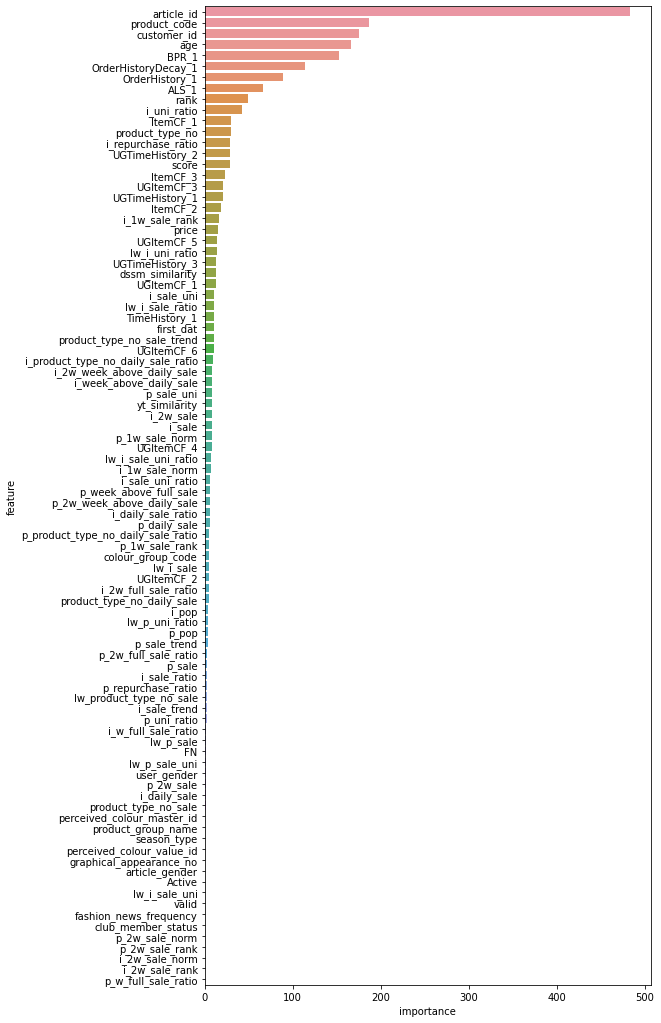

In [ ]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 18))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Validate

In [ ]:
val_candidates = valid.reset_index(drop=True)

In [ ]:
def predict(ranker, candidates, batch_size = 5_000_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
    return pred_lgb

In [ ]:
pred = predict(ranker, val_candidates)

100%|██████████| 68984/68984 [00:06<00:00, 10714.63it/s]


In [ ]:
pred.head()

,customer_id,prediction
0,81,"[53894, 104073, 103109, 94697, 103181, 3092, 1..."
1,87,"[100229, 98607, 33869, 27906, 27908, 102473, 3..."
2,108,"[13043, 2220, 61304, 61305, 61306, 53893, 1794..."
3,118,"[104073, 53894, 94697, 3092, 103109, 42627, 95..."
4,180,"[95217, 104987, 3511, 105181, 104073, 81826, 1..."


In [ ]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

In [ ]:
map_at_k(label["article_id"], label["prediction"], k=12)

# 0.02820525160663368 1-week add normalization
# 0.028936597823123886 4-week min_pos_rate 0.006 0.0274
# 0.029111989281461418 4-week drop full-negative customer
# 0.029165419468984943 3-week 0.0270
# 0.028694388096248934 4-week min_pos_rate 0.005 lr=0.03
# 0.028927037894290773 4-week min_pos_rate 0.005 lr=0.01
# 0.028936597823123886 4-week min_pos_rate 0.005 lr=0.01 max_depth=9, num_leaves=256

# 0.02184774486112968
# 0.021299757514744458
# 0.024265585916471977

# 0.025168746198396853

0.029497050662508465

In [ ]:
recall_at_k(label["article_id"], label["prediction"], k=44)#0.18282943194751883

0.1234544551816865

### Test

In [ ]:
del val_candidates, candidates
gc.collect()

44

In [ ]:
idx2uid = pickle.load(open(data_dir/"index_id_map/user_index2id.pkl", "rb"))
idx2iid = pickle.load(open(data_dir/"index_id_map/item_index2id.pkl", "rb"))
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))

In [ ]:
def parse(x):
    l = ['0'+str(idx2iid[i]) for i in x]
    l = ' '.join(l[:12])
    return l

In [ ]:
for i in range(TEST_BATCH_NUM):
    test_candidates = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week0_candidate_{i}.pqt")
    for feat in cat_features:
        test_candidates[feat] = test_candidates[feat].astype(cate_dict[feat])
    test_pred = predict(ranker, test_candidates)
    test_pred['prediction'] = test_pred['prediction'].progress_apply(lambda x: parse(x))
    submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
    submission['customer_id'] = submission['customer_id'].map(uid2idx)
    del submission['prediction']
    submission = submission.merge(test_pred, on='customer_id', how='right')
    submission['customer_id'] = submission['customer_id'].map(idx2uid)
    submission.to_csv(f'submission_{i}.csv', index=False)

In [ ]:
submit = []
for i in range(TEST_BATCH_NUM):
    submit.append(pd.read_csv(f'submission_{i}.csv'))

In [ ]:
submit = pd.concat(submit, ignore_index=False)
submit.to_csv('submitssion.csv', index=False)